In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 3.0 MB/s eta 0:00:00


In [15]:
import os
import pandas as pd
from dataclasses import dataclass
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [6]:
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.4/251.4 kB 2.2 MB/s eta 0:00:00


In [7]:
data = pd.read_excel("/content/drive/MyDrive/SD 2024/train_without_stopwords.xlsx")
data.head()

,Unnamed: 0,text,label,text_cleansing,text_cleansing2
0,0,Kunjungan Prabowo ini untuk meresmikan dan men...,5,kunjung proyek bantu air bersih lima titik sub...,kunjung proyek bantu air bersih lima titik sub...
1,1,RT Anies dapat tepuk tangan meriah saat jadi R...,0,dapat tepuk tangan riah saat rektor mata kulia...,dapat tepuk tangan riah saat rektor mata kulia...
2,2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,6,bener sih goblok begitu turut ridwan kamil ske...,bener sih goblok begitu turut ridwan kamil ske...
3,3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,0,waktu sikap kritis kerja anggap engga sopan ka...,waktu sikap kritis kerja anggap engga sopan ka...
4,4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,0,baswedan harap asn masuk tni polri pegang sump...,baswedan harap asn masuk tni polri pegang sump...


In [64]:
# Prepare data for modeling
X = data_nonull['text_cleansing2']
y = data_nonull['label']
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

In [10]:
label_dict = {
    'Politik': 0,
    'Sosial Budaya': 1,
    'Pertahanan dan Keamanan': 2,
    'Ideologi': 3,
    'Ekonomi': 4,
    'Sumber Daya Alam': 5,
    'Demografi': 6,
    'Geografi': 7
}

In [65]:
# Define configurations for training models
class ModelTrainerConfig:
    trained_model_file_path: str = os.path.join("artifacts", "models")

In [66]:
# Set up multiple machine learning models for comparison
models = {
    'logistic_regression': LogisticRegression(),
    'decision_tree': DecisionTreeClassifier(),
    'random_forest': RandomForestClassifier(),
    'xgboost': XGBClassifier(),
    'svm': SVC()
}

In [67]:
# Define hyperparameters for GridSearchCV
param_grids = {
    'logistic_regression': {'penalty': ['l1', 'l2'], 'solver': ['lbfgs', 'liblinear']},
    'decision_tree': {'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5, 10]},
    'random_forest': {'n_estimators': [100, 200, 500], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 5, 10]},
    'xgboost': {'learning_rate': [0.01, 0.1, 0.5], 'max_depth': [3, 5, 10], 'n_estimators': [100, 200, 500]},
    'svm': {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}
}

In [71]:
class ModelTrainer:
    def __init__(self):
        self.config = ModelTrainerConfig()

    def train_model(self, model, model_name, param_grid, X_train, y_train, X_test, y_test):
        print(f"Training {model_name}")
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        print(f"Best {model_name} model: {best_model}")
        print(f"Best {model_name} parameters: {best_params}")
        print(f"Best {model_name} score: {best_score}")

        y_pred = best_model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        test_recall = recall_score(y_test, y_pred, average='macro')
        print(f"{model_name} test accuracy: {test_accuracy}")
        print(f"{model_name} test recall: {test_recall}")

        return best_model, best_params, best_score, test_accuracy, test_recall

    def initiate_model_training(self, X_train, y_train, X_test, y_test):
        model_results = {}
        for model_name, model in models.items():
            param_grid = param_grids.get(model_name, {})
            best_model, best_params, best_score, test_accuracy, test_recall = self.train_model(
                model, model_name, param_grid, X_train, y_train, X_test, y_test
            )
            model_results[model_name] = {
                'best_model': best_model,
                'best_params': best_params,
                'best_score': best_score,
                'test_accuracy': test_accuracy,
                'test_recall': test_recall
            }
        return model_results

In [72]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
# Initialize the trainer and start the training process
trainer = ModelTrainer()
results = trainer.initiate_model_training(X_train, y_train, X_test, y_test)

Training logistic_regression


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver 

Best logistic_regression model: LogisticRegression()
Best logistic_regression parameters: {'penalty': 'l2', 'solver': 'lbfgs'}
Best logistic_regression score: 0.7223782234058238
logistic_regression test accuracy: 0.7414829659318637
logistic_regression test recall: 0.373485012979088
Training decision_tree
Best decision_tree model: DecisionTreeClassifier(max_depth=15, min_samples_split=5)
Best decision_tree parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 5}
Best decision_tree score: 0.6960712168405996
decision_tree test accuracy: 0.7014028056112225
decision_tree test recall: 0.3522629809890363
Training random_forest
Best random_forest model: RandomForestClassifier(min_samples_split=10, n_estimators=500)
Best random_forest parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 500}
Best random_forest score: 0.7587096652770852
random_forest test accuracy: 0.7725450901803608
random_forest test recall: 0.44808783459128465
Trainin

# Testing

In [74]:
data_test = pd.read_excel("/content/drive/MyDrive/SD 2024/test_without_stopwords.xlsx")

In [75]:
data_test.head()

,Unnamed: 0,IDText,Text,text_cleansing,text_cleansing2
0,0,TXT0001,Lu mau org2 pro-demokrasi di negara ini bisa p...,mau org negara ini bisa punya lagi buat ngelaw...,mau org negara punya lagi buat oligarki indo p...
1,1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...,prabowo tanya soal hutang luar negeri dia jawa...,tanya soal hutang luar negeri dia jawab hutang...
2,2,TXT0003,kiki_daliyo Ganjar Pranowo itulah beliau soso...,ganjar pranowo itu beliau sosok yang nilai nil...,beliau sosok nilai nilai pancasila banyak sada...
3,3,TXT0004,@kumparan Prabowo Gibran yang bisa melakukan i...,prabowo gibran yang bisa laku itu semua demi r...,gibran laku semua demi
4,4,TXT0005,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...,lah justru gak nyambung junjung elu etika tapi...,lah justru gak nyambung junjung elu etika tapi...


In [76]:
data_test_nonull = data_test.dropna().reset_index(drop=True)
X_new_test = data_test_nonull['text_cleansing2']
X_new_test_vect = vectorizer.transform(X_new_test)

In [77]:
best_model = SVC(C=10, gamma=1)
best_model.fit(X_train, y_train)

SVC(C=10, gamma=1)

In [78]:
y_new_pred = best_model.predict(X_new_test_vect)

In [84]:
# Convert numerical predictions back to labels if necessary
reverse_label_dict = {v: k for k, v in label_dict.items()}
predicted_labels_categorical = [reverse_label_dict[label] for label in y_new_pred]

# Create a DataFrame to show the predicted labels with the corresponding texts
result_df = data_test_nonull.copy()
result_df['Kelas_svc'] = predicted_labels_categorical

In [85]:
result_df

,Unnamed: 0,IDText,Text,text_cleansing,text_cleansing2,Kelas_svc
0,0,TXT0001,Lu mau org2 pro-demokrasi di negara ini bisa p...,mau org negara ini bisa punya lagi buat ngelaw...,mau org negara punya lagi buat oligarki indo p...,Politik
1,1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...,prabowo tanya soal hutang luar negeri dia jawa...,tanya soal hutang luar negeri dia jawab hutang...,Politik
2,2,TXT0003,kiki_daliyo Ganjar Pranowo itulah beliau soso...,ganjar pranowo itu beliau sosok yang nilai nil...,beliau sosok nilai nilai pancasila banyak sada...,Politik
3,3,TXT0004,@kumparan Prabowo Gibran yang bisa melakukan i...,prabowo gibran yang bisa laku itu semua demi r...,gibran laku semua demi,Politik
4,4,TXT0005,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...,lah justru gak nyambung junjung elu etika tapi...,lah justru gak nyambung junjung elu etika tapi...,Politik
...,...,...,...,...,...,...
995,995,TXT0996,"Bikin bangga deh, Ganjar-Mahfud mau alokasikan...",bikin bangga deh mau tengah dari belanja dan b...,bikin bangga deh mau tengah belanja bumn buat ...,Politik
996,996,TXT0997,Pak Jokowi sebelum pilpres 2024 berbesar hati ...,pak jokowi belum pilpres besar hati rangkul pa...,jokowi belum pilpres besar hati rangkul pun de...,Politik
997,997,TXT0998,@datuakrajoangek Sbaiknya si gemot nga usah ik...,baik remot nga usah ikut debat denga jelas mau...,baik remot nga usah ikut debat denga jelas mau...,Politik
998,998,TXT0999,kebiasaan merembuk atau bermusyawarah jadi gay...,biasa rembuk atau jadi gaya ganjar sejak jadi ...,biasa rembuk atau gaya sejak gubernur jateng g...,Ekonomi


In [82]:
result_bert = pd.read_csv("/content/drive/MyDrive/SD 2024/SD2024040000011.csv")

In [86]:
compare_result = pd.merge(result_df[['IDText', 'Text', 'text_cleansing2', 'Kelas_svc']], result_bert[['IDText', 'Kelas']], on='IDText', how='inner')

In [88]:
compare_result.rename(columns={'Kelas': 'Kelas_IndoBERT', }, inplace=True)

In [89]:
compare_result

,IDText,Text,text_cleansing2,Kelas_svc,Kelas_IndoBERT
0,TXT0001,Lu mau org2 pro-demokrasi di negara ini bisa p...,mau org negara punya lagi buat oligarki indo p...,Politik,Politik
1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...,tanya soal hutang luar negeri dia jawab hutang...,Politik,Ekonomi
2,TXT0003,kiki_daliyo Ganjar Pranowo itulah beliau soso...,beliau sosok nilai nilai pancasila banyak sada...,Politik,Politik
3,TXT0004,@kumparan Prabowo Gibran yang bisa melakukan i...,gibran laku semua demi,Politik,Politik
4,TXT0005,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...,lah justru gak nyambung junjung elu etika tapi...,Politik,Politik
...,...,...,...,...,...
995,TXT0996,"Bikin bangga deh, Ganjar-Mahfud mau alokasikan...",bikin bangga deh mau tengah belanja bumn buat ...,Politik,Politik
996,TXT0997,Pak Jokowi sebelum pilpres 2024 berbesar hati ...,jokowi belum pilpres besar hati rangkul pun de...,Politik,Politik
997,TXT0998,@datuakrajoangek Sbaiknya si gemot nga usah ik...,baik remot nga usah ikut debat denga jelas mau...,Politik,Politik
998,TXT0999,kebiasaan merembuk atau bermusyawarah jadi gay...,biasa rembuk atau gaya sejak gubernur jateng g...,Ekonomi,Ekonomi


In [90]:
compare_result.to_excel("/content/drive/MyDrive/SD 2024/svm_vs_indobert.xlsx")

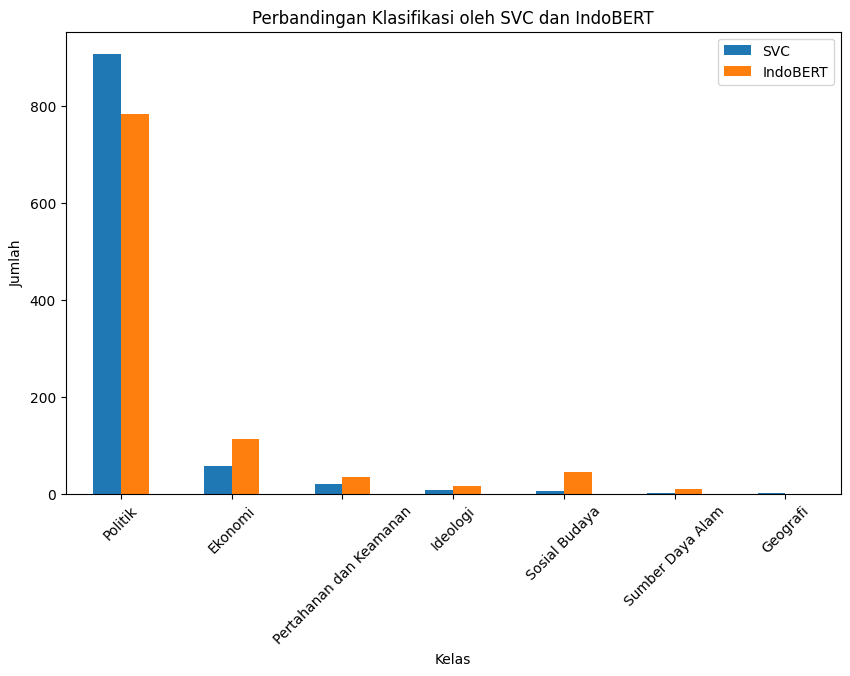

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

svc_counts = compare_result['Kelas_svc'].value_counts()
indobert_counts = compare_result['Kelas_IndoBERT'].value_counts()

comparison_df = pd.DataFrame([svc_counts, indobert_counts])
comparison_df.index = ['SVC', 'IndoBERT']
comparison_df = comparison_df.T  # Transpose untuk membuat bar chart lebih mudah

comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title('Perbandingan Klasifikasi oleh SVC dan IndoBERT')
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.show()

In [98]:
different_classification = compare_result[compare_result['Kelas_svc'] != compare_result['Kelas_IndoBERT']]
new_df = different_classification[['IDText', 'Text', 'Kelas_svc', 'Kelas_IndoBERT']]

new_df

,IDText,Text,Kelas_svc,Kelas_IndoBERT
1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...,Politik,Ekonomi
9,TXT0010,Ganjar-Mahfud adalah harapan baru untuk pertum...,Politik,Ekonomi
17,TXT0018,"Dengan Ganjar-Mahfud, kita bisa berharap penin...",Politik,Ekonomi
18,TXT0019,Kampanye politik Anies dalam Pilgub DKI mempen...,Politik,Ekonomi
23,TXT0024,@RM55Bn/jTOYBntGhLJUBSxbB+yKFrIWQVNDlunZ3qJo= ...,Politik,Sosial Budaya
...,...,...,...,...
971,TXT0972,Keamanan data dijaga serius Ganjar-Mahfud eman...,Politik,Pertahanan dan Keamanan
972,TXT0973,Pernyataan Prabowo ttg Gaza dilindas karena le...,Politik,Pertahanan dan Keamanan
980,TXT0981,Ganjar Pranowo Keren Ganjar Bersama Rakyat yan...,Politik,Ideologi
982,TXT0983,"Heppy Weekend, Sis dan Bro. Tadi pagi Mas Ketu...",Politik,Sosial Budaya


In [99]:
new_df.to_excel("/content/drive/MyDrive/SD 2024/diff_class_svm_vs_indobert.xlsx")